In [4]:
from scipy.io import loadmat
from utils import *
data = loadmat('emnist-digits.mat')

In [5]:
import matplotlib.pyplot as plt
import numpy as np


In [6]:
dataset = data['dataset'][0, 0]
train = dataset[0][0, 0]  
test = dataset[1][0, 0]  
mapping = dataset[2]

train_images = train['images']   # Shape: (N, 28*28)
train_labels = train['labels']  # Shape: (N, 1)
train_writers = train['writers']

In [7]:
X = train_images.astype(np.float32) / 255.0  # Normalize to [0, 1]
y = train_labels.flatten().astype(np.int64)

# Wrap into a datalist with a single client
datalist = [(X, y)]

test_images = test['images'].astype(np.float32) / 255.0
test_labels = test['labels'].flatten().astype(np.int64)


In [5]:
from features_utils import *

In [6]:
n_clients = 30
datalist = make_femnist_datasets(X,y,train,n_clients)
# Hyperparameters
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate
print(f"case with {n_clients} clients, with feature distribution shift")
model = fedavg(datalist, T, K, gamma)


case with 30 clients, with feature distribution shift
round :  1
round :  2
round :  3
round :  4
round :  5


In [7]:
# Evaluate
test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")

Test Accuracy with 30 ): 81.02%


In [8]:
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate

# 1) Create MADE data loaders (unchanged)
made_loaders = [
    DataLoader(
        TensorDataset(
            torch.tensor(X, dtype=torch.float32),
            torch.zeros(len(X), dtype=torch.float32)
        ),
        batch_size=64,
        shuffle=True
    )
    for X, _ in datalist
]

# 2) Train global MADE (unchanged)
global_made = train_global_made(
    made_loaders,
    dim=28*28,
    hid=100,
    rounds=T,
    local_epochs=1
)

# 3) Compute sample-weights α for each client (unchanged)
sample_weights = []
for ld in made_loaders:
    local_made = MADE(28*28, 100)
    local_state = train_local_made(local_made, ld, epochs=1)
    local_made.load_state_dict(local_state)

    alpha = compute_sample_weights(global_made, local_made, ld)
    # alpha is a FloatTensor of shape [n_samples] for this client
    sample_weights.append(alpha)

# ─────────────────────────────────────────────────────────────────────────────
# 4) Instead of oversampling, just record:
#      - alphas_list (one α-tensor per client)
#      - client_sizes (one integer per client)
#    and leave datalist as-is.

alphas_list = sample_weights                  # list of length n_clients, each α has shape (N_k,)
client_sizes = [ len(y) for (_, y) in datalist ]  # e.g. [N_1, N_2, ..., N_K]

# 5) Call the new fedavg signature directly on (X,y), alphas_list, and client_sizes
print(f"case with {len(datalist)} clients, with feature distribution shift")
model = fedavg_disk(
    datalist,       # unchanged: [(X1, y1), (X2, y2), …]
    alphas_list,    # per-sample weights from Phase 1
    client_sizes,   # [len(y1), len(y2), …]
    T, K, gamma
)

case with 30 clients, with feature distribution shift


In [9]:

test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")

Test Accuracy with 30 ): 89.72%


 ### On obtaining loss curves and convergence rates of the loss function

With loss log 

In [10]:
import importlib
import utils
importlib.reload(utils)

from utils import fedavg_loss

In [11]:
# Train

model, loss_curve = fedavg_loss(datalist, T=20, K=5, gamma=0.1, print_every = 10, weights=None)

#print(loss_curve)

# Compute convergence rates
abs_dec = compute_convergence(loss_curve)

# Example printout
#for r in range(T):
    #print(f"Round {r+1}→{r+2}: abs drop = {abs_dec[r]:.4f}, rel drop = {rel_dec[r]:.4%}")



test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")


KeyboardInterrupt: 

### Just some plots of loss curve : No relation with convergence rates, just the shape of the loss

In [ ]:
model, loss_curve = fedavg_loss(datalist, T=200, K=5, gamma=0.1, print_every = 10, weights=None)

#print(loss_curve)

# Compute convergence rates
abs_dec = compute_convergence(loss_curve)

# Example printout
#for r in range(T):
    #print(f"Round {r+1}→{r+2}: abs drop = {abs_dec[r]:.4f}, rel drop = {rel_dec[r]:.4%}")



test_accuracy = evaluate(model, test_images, test_labels)
print(f"Test Accuracy with {n_clients} ): {test_accuracy * 100:.2f}%")

  Avg training loss at round 10: 0.8712
  Avg training loss at round 20: 0.4824
  Avg training loss at round 30: 0.3858
  Avg training loss at round 40: 0.3422
  Avg training loss at round 50: 0.3164
  Avg training loss at round 60: 0.2987
  Avg training loss at round 70: 0.2855
  Avg training loss at round 80: 0.2748
  Avg training loss at round 90: 0.2659
  Avg training loss at round 100: 0.2581
  Avg training loss at round 110: 0.2511
  Avg training loss at round 120: 0.2447
  Avg training loss at round 130: 0.2388
  Avg training loss at round 140: 0.2333
  Avg training loss at round 150: 0.2280
  Avg training loss at round 160: 0.2230
  Avg training loss at round 170: 0.2183


KeyboardInterrupt: 

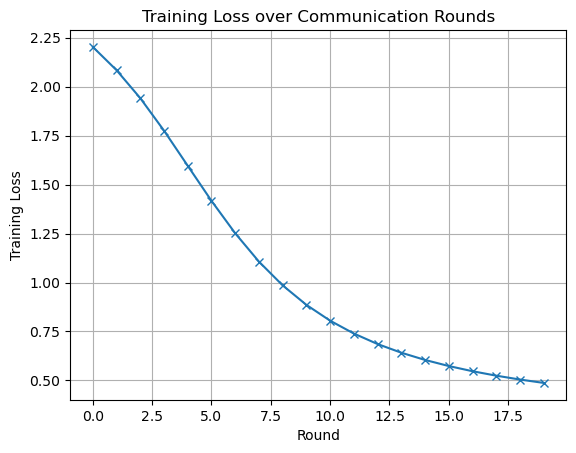

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_curve, marker='x')
plt.xlabel("Round")
plt.ylabel("Training Loss")
plt.title("Training Loss over Communication Rounds")
plt.grid(True)
plt.show()


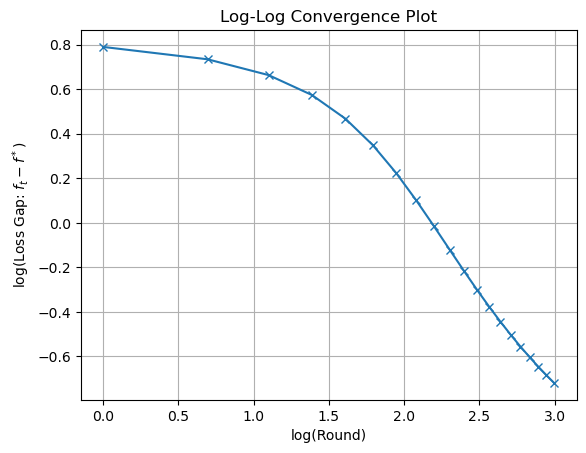

In [ ]:
import numpy as np

rounds = np.arange(1, len(loss_curve) + 1)
plt.plot(np.log(rounds), np.log(loss_curve), marker='x')
plt.xlabel("log(Round)")
plt.ylabel("log(Loss Gap: $f_t - f^*$)")
plt.title("Log-Log Convergence Plot")
plt.grid(True)
plt.show()


Parameter K

### Run experiments varying number of local steps K

In [1]:
import importlib
import utils
importlib.reload(utils)
from utils import *

In [8]:



run_experiments(
    datalist=datalist,
    param_name='K',
    param_values=[1, 5, 10,20,30,40],
    fixed_params={'T': 20, 'gamma': 0.01},
    loglog=True)


NameError: name 'run_experiments' is not defined

In [9]:
run_experiment(
    datalist=datalist,
    param_name='K',
    param_values=[1,3,5,7,10,12,15],
    fixed_params={'T': 20, 'gamma': 0.01},
    loglog=False)

TypeError: run_experiment() got an unexpected keyword argument 'param_name'


### I don't know if super useful


### Trying some other plots

### Varying T



In [ ]:
import importlib
import utils
importlib.reload(utils)
from utils import *

In [ ]:
import matplotlib.pyplot as plt

K      = 10             #number of local GD steps per round
gamma  = 0.1           #learning rate for each GD step
T_list = [5,10,15,20,25,30,35,40,45,50,55,60,65,70]  #the different global rounds numbers

#averaging to reduce variance
average_last_n = 5

final_losses = sample_final_losses_vs_T(datalist, T_list, K, gamma, average_last_n)




  → T=5, final averaged loss = 1.3984
  → T=10, final averaged loss = 0.5702
  → T=15, final averaged loss = 0.4074
  → T=20, final averaged loss = 0.3474
  → T=25, final averaged loss = 0.3181
  → T=30, final averaged loss = 0.2970
  → T=35, final averaged loss = 0.2801
  → T=40, final averaged loss = 0.2702
  → T=45, final averaged loss = 0.2590
  → T=50, final averaged loss = 0.2509
  → T=55, final averaged loss = 0.2450
  → T=60, final averaged loss = 0.2375
  → T=65, final averaged loss = 0.2318
  → T=70, final averaged loss = 0.2268


Estimated convergence exponent α ≈ 0.5992,  C ≈ 2.522e+00


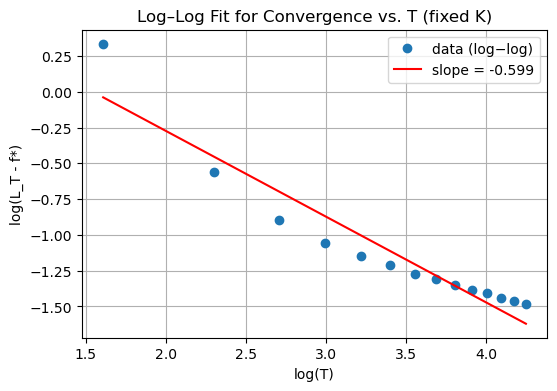

In [ ]:
# 1) Build arrays
T_arr   = np.array(sorted(final_losses.keys()))
L_arr   = np.array([ final_losses[T] for T in T_arr ])

# 2) Choose a reference f_star (e.g. centralized baseline or min(L_arr))
f_star  = 0

# 3) Compute error e_T = L_arr - f_star
errors  = np.clip(L_arr - f_star, 1e-12, None)

# 4) Fit log(e_T) vs. log(T) to extract slope “-alpha”:
logT    = np.log(T_arr)
logErr  = np.log(errors)
A       = np.vstack([logT, np.ones_like(logT)]).T
alpha_neg, intercept = np.linalg.lstsq(A, logErr, rcond=None)[0]
alpha   = -alpha_neg
C_est   = np.exp(intercept)

print(f"Estimated convergence exponent α ≈ {alpha:.4f},  C ≈ {C_est:.3e}")

# 5) (Optional) Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(logT, logErr, 'o', label="data (log−log)")
xfit = np.linspace(logT.min(), logT.max(), 100)
yfit = alpha_neg * xfit + intercept
plt.plot(xfit, yfit, 'r-', label=f"slope = {alpha_neg:.3f}")
plt.xlabel("log(T)")
plt.ylabel("log(L_T - f*)")
plt.title("Log–Log Fit for Convergence vs. T (fixed K)")
plt.legend()
plt.grid(True)
plt.show()


### Varying K

In [ ]:
import importlib
import utils
importlib.reload(utils)
from utils import *

In [ ]:
import matplotlib.pyplot as plt

T     = 10             #number of local GD steps per round
gamma  = 0.1           #learning rate for each GD step
K_list = [5,10,15,30,45,60]  #the different global rounds numbers

#averaging to reduce variance
average_last_n = 5

final_losses = sample_final_losses_vs_K(datalist, T, K_list, gamma, average_last_n)

  → K=5, final averaged loss = 1.0775
  → K=10, final averaged loss = 0.5657
  → K=15, final averaged loss = 0.4297
  → K=30, final averaged loss = 0.3112
  → K=45, final averaged loss = 0.2682
  → K=60, final averaged loss = 0.2443


In [ ]:
print(final_losses)

{5: 1.0775312546888987, 10: 0.5656647491455078, 15: 0.4297484040260315, 30: 0.3111988884210587, 45: 0.26815242667992906, 60: 0.24433030486106871}


K_arr: [ 5 10 15 30 45 60]
L_arr: [1.07753125 0.56566475 0.4297484  0.31119889 0.26815243 0.2443303 ]
Using f* = 0.0000
Fit: L(K) ≈ 2.336e+00 * K^(-0.576),  R² = 0.9591


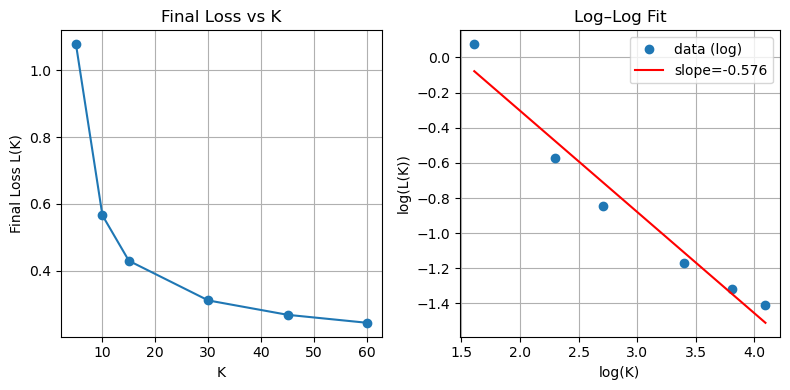

In [ ]:
K_arr = np.array(sorted(final_losses.keys()))           
# Build the corresponding losses (in the same order)
L_arr = np.array([final_losses[K] for K in K_arr])     

print("K_arr:", K_arr)
print("L_arr:", L_arr)

# ── 4) Choose a reference f_star ──
# If you have a centralized baseline loss, use it. Otherwise, use min(L_arr).
f_star = 0
print(f"Using f* = {f_star:.4f}")

# Compute the “error” e_K = L_K - f_star
errors = np.clip(L_arr - f_star, 1e-12, None)  # never let it go to zero


# For a power‐law fit e_K ≈ C / (T·K)^α, we do a regression on (log(TK), log(errors))
logK  = np.log(K_arr)
logL  = np.log(L_arr)             # or np.log(errors) if using f*

A = np.vstack([logK, np.ones_like(logK)]).T
m, b = np.linalg.lstsq(A, logL, rcond=None)[0]
alpha_est = -m       # exponent, since L ≈ C·K^{-α} → logL ≈ −α·logK + log C
C_est     = np.exp(b) 

y_pred = m*logK + b
ss_res = np.sum((logL - y_pred)**2)
ss_tot = np.sum((logL - np.mean(logL))**2)
r2     = 1 - (ss_res/ss_tot)
print(f"Fit: L(K) ≈ {C_est:.3e} * K^(-{alpha_est:.3f}),  R² = {r2:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
# (a) raw L vs K
plt.subplot(1,2,1)
plt.plot(K_arr, L_arr, 'o-')
plt.xlabel("K")
plt.ylabel("Final Loss L(K)")
plt.title("Final Loss vs K")
plt.grid(True)

# (b) log–log plot and fitted line
plt.subplot(1,2,2)
plt.plot(logK, logL, 'o', label="data (log)")
xfit = np.linspace(logK.min(), logK.max(), 100)
yfit = m*xfit + b
plt.plot(xfit, yfit, 'r-', label=f"slope={m:.3f}")
plt.xlabel("log(K)")
plt.ylabel("log(L(K))")
plt.title("Log–Log Fit")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Trying moon with features_shift 

### But should not improve much the performance. It is better suited for Label Shift


In [ ]:
import importlib
import utils
importlib.reload(utils)
from utils import *

In [ ]:
n_clients = 30
datalist = make_femnist_datasets(X,y,train,n_clients)
# Hyperparameters
T = 5       # number of global rounds
K = 10      # number of client GD steps
gamma = 0.1 # learning rate
print(f" MOON : case with {n_clients} clients, with feature distribution shift")

 MOON : case with 30 clients, with feature distribution shift


In [ ]:
model, loss_curve = fedavg_moon(datalist, T=T, K=K, gamma=gamma, mu=0.5)

In [ ]:
test_accuracy = evaluate(model, test_images, test_labels)
print(test_accuracy)

0.8402249813079834


##### It indeed doesn't make a difference from FedAvg